The notebook was built based on Gene Kogan's "neural-synth" notebook. Before we get started, we need to make sure we have downloaded and placed the Inceptionism network in the data folder. Run the next cell if you haven't already downloaded it.

In [1]:
#Grab inception model from online and unzip it (you can skip this step if you've already downloaded the model.

#!wget -P ../data/ https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
#!unzip ../data/inception5h.zip -d ../data/inception5h/
#!rm ../data/inception5h.zip

To get started, make sure all of the folloing import statements work without error. You should get a message telling you there are 59 layers in the network and 7548 channels.

In [2]:
from __future__ import print_function
from io import BytesIO
import math, time, copy, json, os
import glob
from os import listdir
from os.path import isfile, join
from random import random
from io import BytesIO
from enum import Enum
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
import numpy as np
import scipy.misc
import tensorflow as tf
from lapnorm import *


Number of layers 59
Total number of feature channels: 7548


Let's inspect the network now. The following will give us the name of all the layers in the network, as well as the number of channels they contain. We can use this as a lookup table when selecting channels.

In [3]:
for l, layer in enumerate(layers):
    layer = layer.split("/")[1]
    num_channels = T(layer).shape[3]
    print(layer, num_channels)

conv2d0_pre_relu 64
conv2d1_pre_relu 64
conv2d2_pre_relu 192
mixed3a_1x1_pre_relu 64
mixed3a_3x3_bottleneck_pre_relu 96
mixed3a_3x3_pre_relu 128
mixed3a_5x5_bottleneck_pre_relu 16
mixed3a_5x5_pre_relu 32
mixed3a_pool_reduce_pre_relu 32
mixed3b_1x1_pre_relu 128
mixed3b_3x3_bottleneck_pre_relu 128
mixed3b_3x3_pre_relu 192
mixed3b_5x5_bottleneck_pre_relu 32
mixed3b_5x5_pre_relu 96
mixed3b_pool_reduce_pre_relu 64
mixed4a_1x1_pre_relu 192
mixed4a_3x3_bottleneck_pre_relu 96
mixed4a_3x3_pre_relu 204
mixed4a_5x5_bottleneck_pre_relu 16
mixed4a_5x5_pre_relu 48
mixed4a_pool_reduce_pre_relu 64
mixed4b_1x1_pre_relu 160
mixed4b_3x3_bottleneck_pre_relu 112
mixed4b_3x3_pre_relu 224
mixed4b_5x5_bottleneck_pre_relu 24
mixed4b_5x5_pre_relu 64
mixed4b_pool_reduce_pre_relu 64
mixed4c_1x1_pre_relu 128
mixed4c_3x3_bottleneck_pre_relu 128
mixed4c_3x3_pre_relu 256
mixed4c_5x5_bottleneck_pre_relu 24
mixed4c_5x5_pre_relu 64
mixed4c_pool_reduce_pre_relu 64
mixed4d_1x1_pre_relu 112
mixed4d_3x3_bottleneck_pre_relu 

See Gene Kogan's "neural-synth" notebook for a discussion of the below functions

In [4]:
def render_naive(t_obj, img0, iter_n=20, step=1.0):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    img = img0.copy()
    for i in range(iter_n):
        g, score = sess.run([t_grad, t_score], {t_input:img})
        # normalizing the gradient, so the same step size should work 
        g /= g.std()+1e-8         # for different layers and networks
        img += g*step
    return img


In [5]:
def render_multiscale(t_obj, img0, iter_n=10, step=1.0, octave_n=3, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    img = img0.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*octave_scale
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            # normalizing the gradient, so the same step size should work 
            g /= g.std()+1e-8        # for different layers and networks
            img += g*step
        print("octave %d/%d"%(octave+1, octave_n))
    clear_output()
    return img


In [6]:
def render_lapnorm(t_obj, img0, iter_n=10, step=1.0, oct_n=3, oct_s=1.4, lap_n=4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    # build the laplacian normalization graph
    lap_norm_func = tffunc(np.float32)(partial(lap_normalize, scale_n=lap_n))
    img = img0.copy()
    for octave in range(oct_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*oct_s
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            g = lap_norm_func(g)
            img += g*step
            print('.', end='')
        print("octave %d/%d"%(octave+1, oct_n))
    clear_output()
    return img
 

In [7]:
def lapnorm_multi(t_obj, img0, mask, iter_n=10, step=1.0, oct_n=3, oct_s=1.4, lap_n=4, clear=True):
    mask_sizes = get_mask_sizes(mask.shape[0:2], oct_n, oct_s)
    img0 = resize(img0, np.int32(mask_sizes[0])) 
    t_score = [tf.reduce_mean(t) for t in t_obj] # defining the optimization objective
    t_grad = [tf.gradients(t, t_input)[0] for t in t_score] # behold the power of automatic differentiation!
    # build the laplacian normalization graph
    lap_norm_func = tffunc(np.float32)(partial(lap_normalize, scale_n=lap_n))
    img = img0.copy()
    for octave in range(oct_n):
        if octave>0:
            hw = mask_sizes[octave] #np.float32(img.shape[:2])*oct_s
            img = resize(img, np.int32(hw))
        oct_mask = resize(mask, np.int32(mask_sizes[octave]))
        for i in range(iter_n):
            g_tiled = [lap_norm_func(calc_grad_tiled(img, t)) for t in t_grad]
            for g, gt in enumerate(g_tiled):
                img += gt * step * oct_mask[:,:,g].reshape((oct_mask.shape[0],oct_mask.shape[1],1))
            print('.', end='')
        print("octave %d/%d"%(octave+1, oct_n))
    if clear:
        clear_output()
    return img

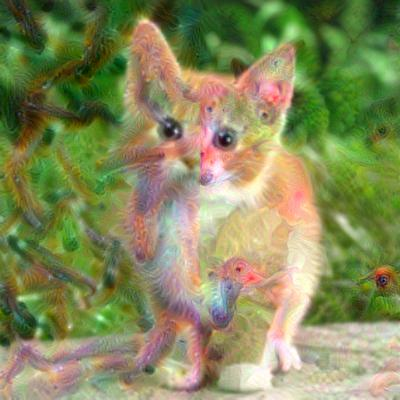

In [8]:
h, w = 400, 400
octave_n = 3
octave_scale = 1.4
iter_n = 10

img0 = load_image('../assets/kitty.jpg', h, w)

objectives = [T('mixed4d_3x3_bottleneck_pre_relu')[:,:,:,125], 
              T('mixed5a_5x5_bottleneck_pre_relu')[:,:,:,30]]

# mask
mask = np.zeros((h, w, 2))
mask[:,:200,0] = 1.0
mask[:,200:,1] = 1.0

img1 = lapnorm_multi(objectives, img0, mask, iter_n, 1.0, octave_n, octave_scale)
display_image(img1)

In [9]:
img0.shape

(400, 400, 3)

In [10]:
img_mtx=img0.reshape(400*400,3)

In [11]:
from keras.utils import np_utils
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [12]:
def plt_img(img):
    plt.figure(figsize=(6, 6))
    plt.axis("off")
    plt.imshow(img)
    plt.colorbar()
    plt.show()

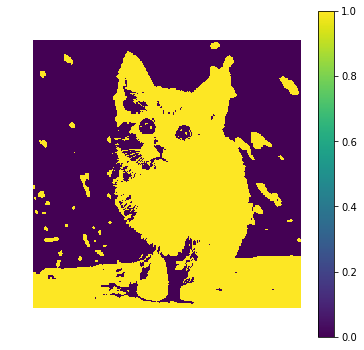

In [13]:
n_clusters=2

kmeans = KMeans(n_clusters)
#kmeans = KMeans(n_clusters, init=centroid)
kmeans.fit(img_mtx)

centroid = kmeans.cluster_centers_
labels = kmeans.labels_
img_labels=labels.reshape(400,400)
plt_img(img_labels)


oneshot_labels = np_utils.to_categorical(labels, n_clusters)
mask=oneshot_labels.reshape(400,400,n_clusters);

/home/barnabas/miniconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:889: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


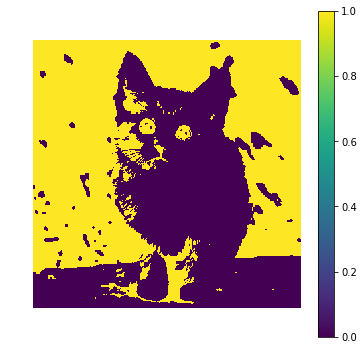

...............octave 1/3
...............octave 2/3
...............octave 3/3


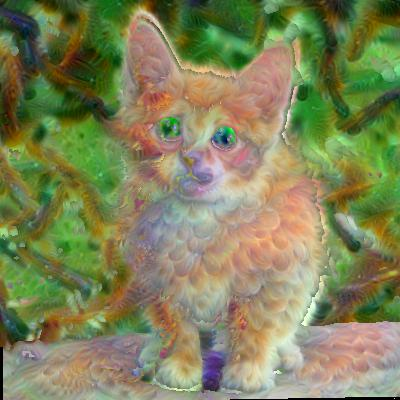

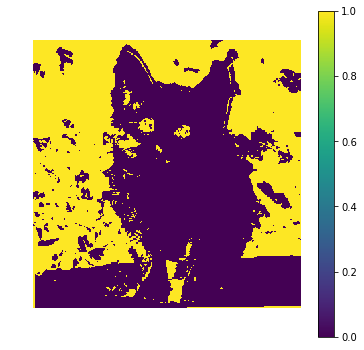

...............octave 1/3
...............octave 2/3
...............octave 3/3


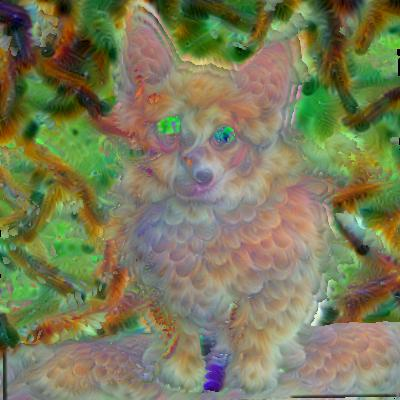

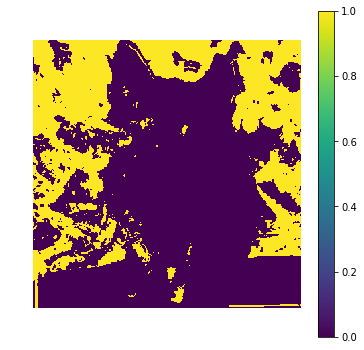

...............octave 1/3
...............octave 2/3
...............octave 3/3


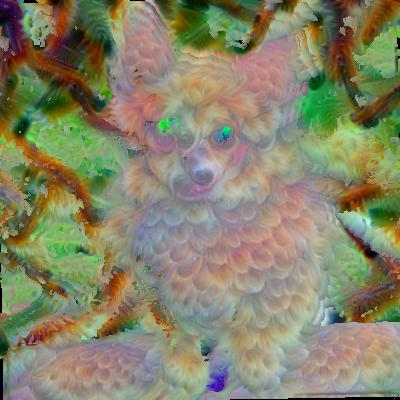

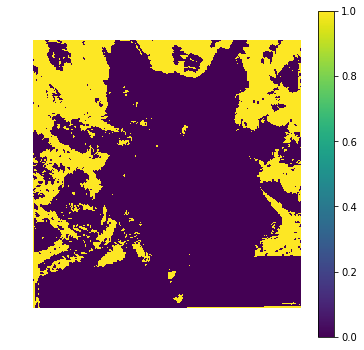

...............octave 1/3
...............octave 2/3
...............octave 3/3


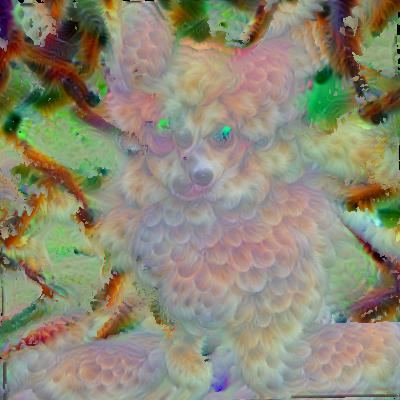

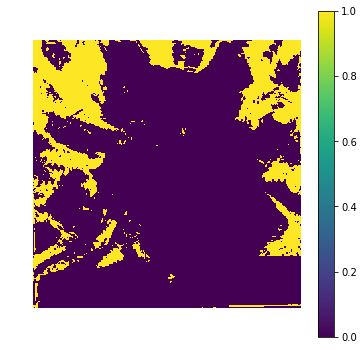

...............octave 1/3
...............octave 2/3
...............octave 3/3


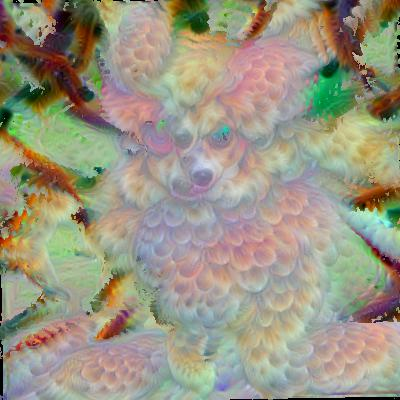

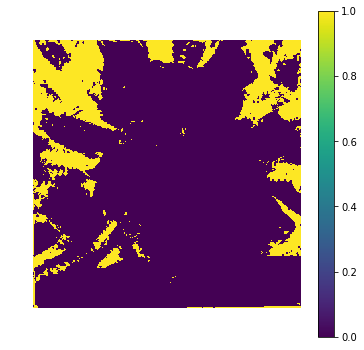

...............octave 1/3
...............octave 2/3
...............octave 3/3


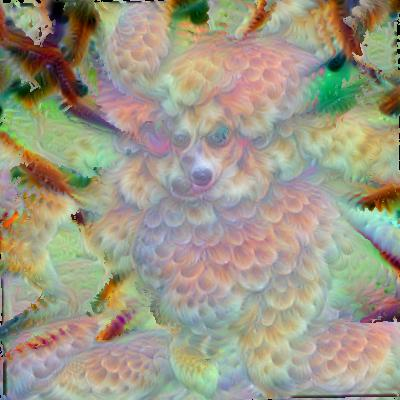

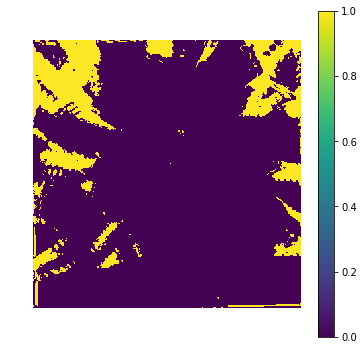

...............octave 1/3
...............octave 2/3
...............octave 3/3


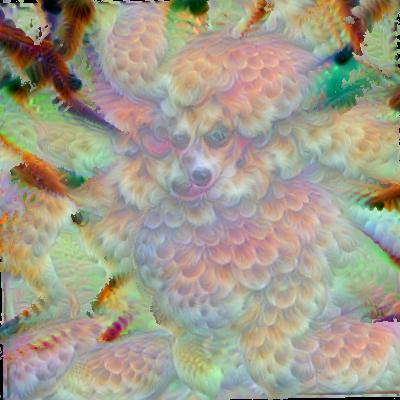

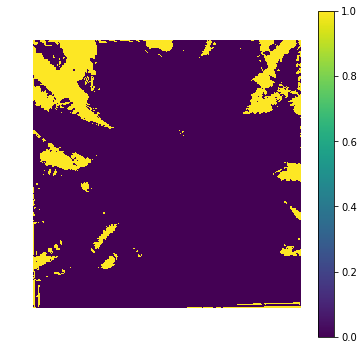

...............octave 1/3
...............octave 2/3
...............octave 3/3


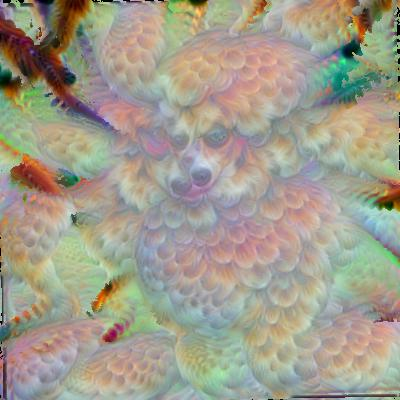

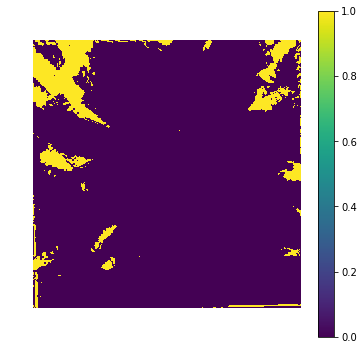

...............octave 1/3
...............octave 2/3
...............octave 3/3


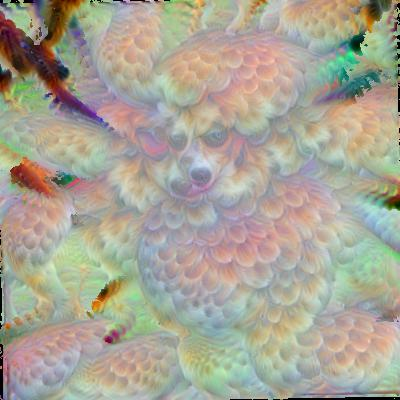

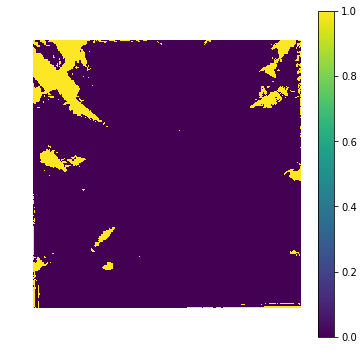

...............octave 1/3
...............octave 2/3
...............octave 3/3


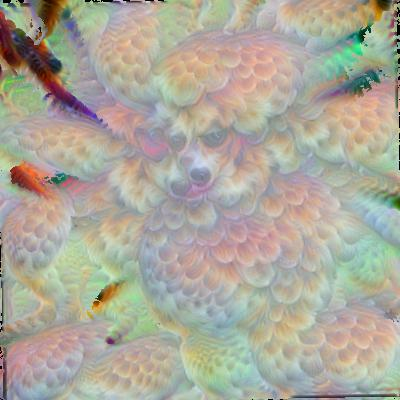

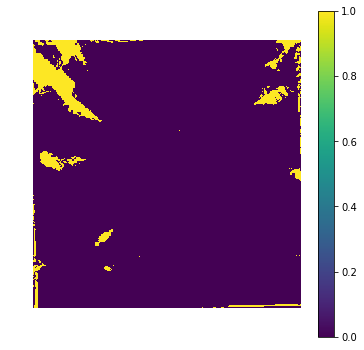

...............octave 1/3
...............octave 2/3
...............octave 3/3


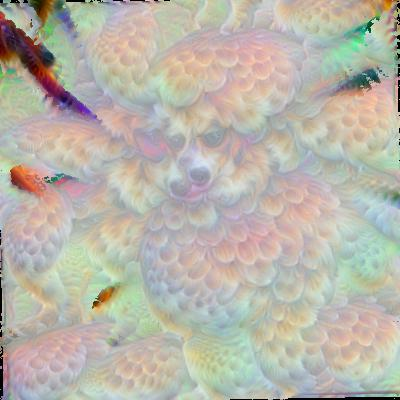

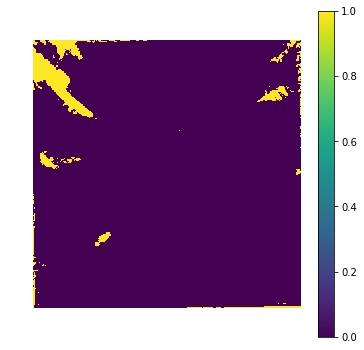

...............octave 1/3
...............octave 2/3
...............octave 3/3


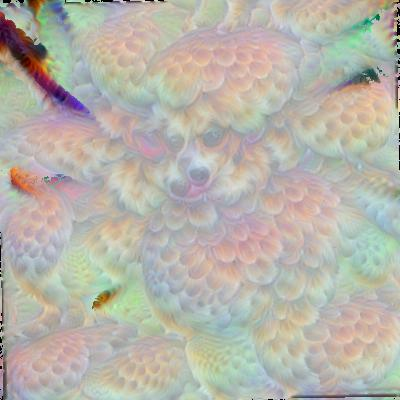

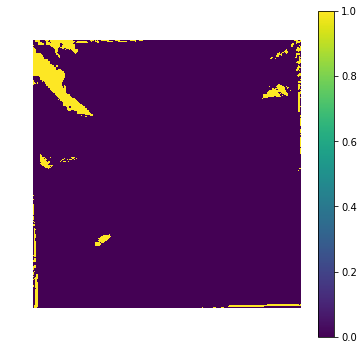

...............octave 1/3
...............octave 2/3
...............octave 3/3


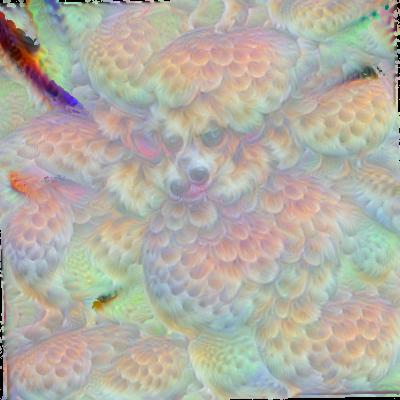

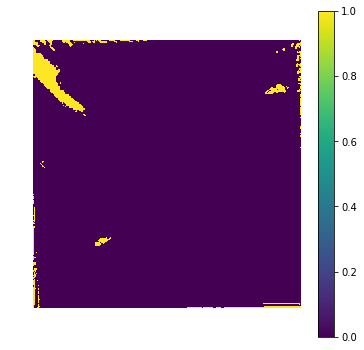

...............octave 1/3
...............octave 2/3
...............octave 3/3


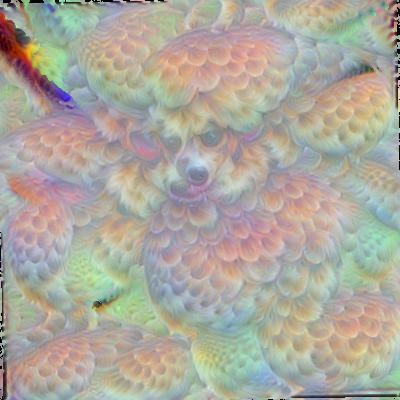

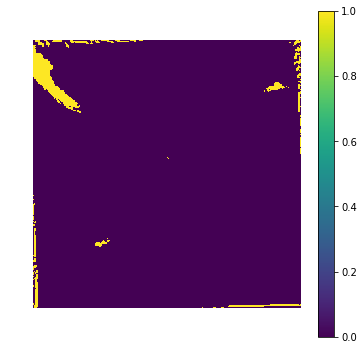

...............octave 1/3
...............octave 2/3
...............octave 3/3


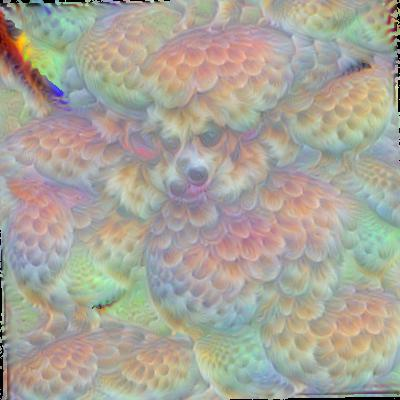

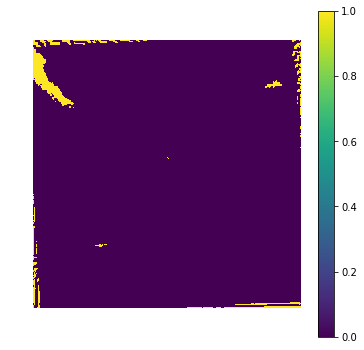

...............octave 1/3
...............octave 2/3
...............octave 3/3


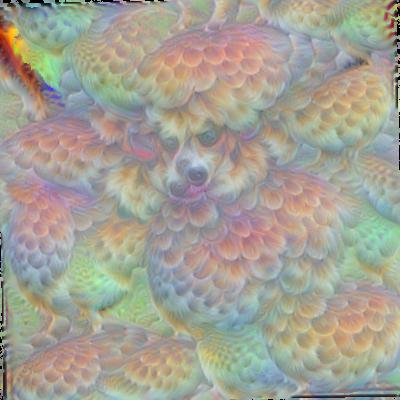

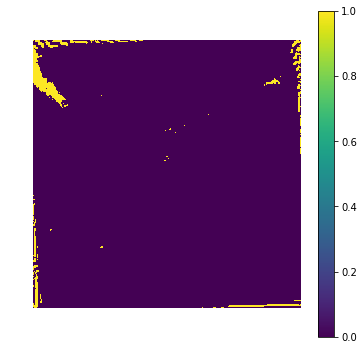

...............octave 1/3
...............octave 2/3
...............octave 3/3


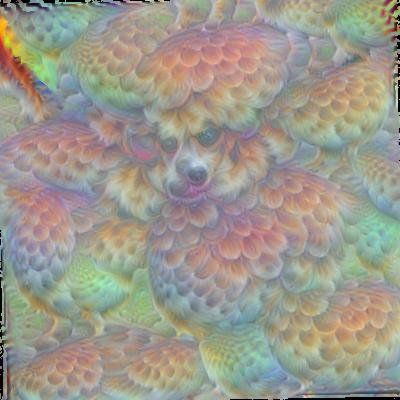

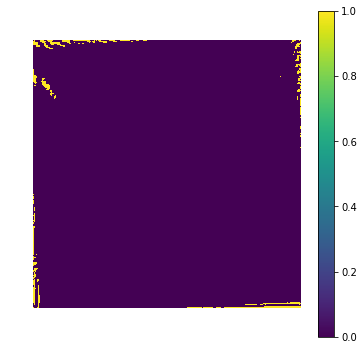

...............octave 1/3
...............octave 2/3
...............octave 3/3


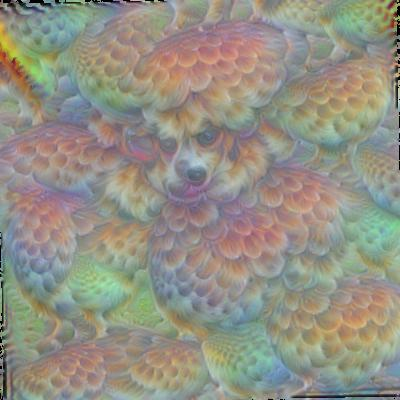

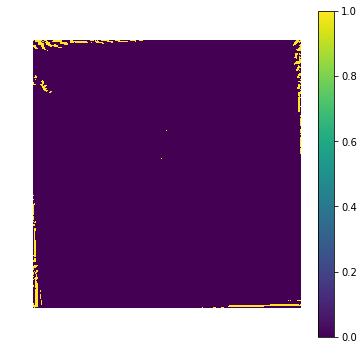

...............octave 1/3
...............octave 2/3
...............octave 3/3


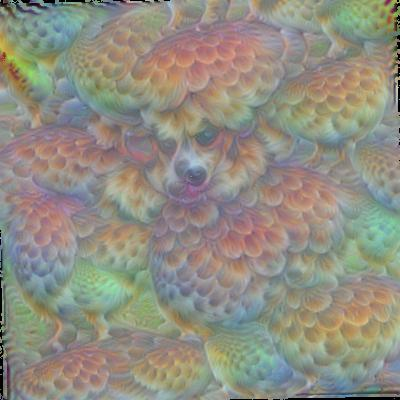

In [14]:
img = load_image('../assets/kitty.jpg', h, w)

n_clusters=2

kmeans = KMeans(n_clusters)
kmeans.fit(img_mtx)

centroid = kmeans.cluster_centers_
labels = kmeans.labels_
img_labels=labels.reshape(400,400)


objectives = [T('mixed4d_5x5_bottleneck_pre_relu')[:,:,:,11],
              T('mixed4d_3x3_bottleneck_pre_relu')[:,:,:,125]  
              ]

#T('mixed5a_5x5_bottleneck_pre_relu')[:,:,:,30]


mask_rgb0=np.zeros((400,400,3))
mask_rgb1=np.zeros((400,400,3))

iter=0
a = np.uint8(np.clip(img, 0, 255))
img2=PIL.Image.fromarray(a) 
img2.save('../results/frames/frame%04d.png'%iter)

# repeat the generation loop n_frames times. notice the feedback -- we make img and then use it the initial input 

n_frames=20
for iter in range(1,n_frames):
    
    img_mtx=img.reshape(400*400,3)
    
    kmeans = KMeans(n_clusters, init=centroid)
    kmeans.fit(img_mtx)

    centroid = kmeans.cluster_centers_
    labels = kmeans.labels_
    
    img_labels=labels.reshape(400,400)
    plt_img(img_labels)

    oneshot_labels = np_utils.to_categorical(labels, n_clusters)
    mask=oneshot_labels.reshape(400,400,n_clusters);

    #creates masks for the RGB channels using the clusters
    mask_rgb0[:,:,0]=mask[:,:,0]
    mask_rgb0[:,:,1]=mask[:,:,0]
    mask_rgb0[:,:,2]=mask[:,:,0]
    
    mask_rgb1[:,:,0]=mask[:,:,1]
    mask_rgb1[:,:,1]=mask[:,:,1]
    mask_rgb1[:,:,2]=mask[:,:,1]
    

    #deep dreaming with the selected  objectives
    img_0 = lapnorm_multi(objectives, img, mask, iter_n=15, step=1.0, oct_n=3, oct_s=1.4, lap_n=4, clear=False)
    img_1 =img_0
    
    
    #animation zooming
    img_1 = resize(img_1[10:-10,10:-10,:], (h, w))# before looping back, crop the border by 10 pixels, resize, repea 
    
    #animation rotating
    img_0 = resize( scipy.misc.imrotate(img_0,1), (h, w))
    
    # combine the two masked images
    img=img_0*mask_rgb0+img_1*mask_rgb1
    
    display_image(img)    # let's see it

    
    a = np.uint8(np.clip(img, 0, 255))
    img2=PIL.Image.fromarray(a) 
    img2.save('../results/frames/frame%04d.png'%iter)

In [15]:
frames_dir = '../results/frames'
video_path = '../results/videos/deep_dream.mp4'

import os
if not os.path.isdir(frames_dir):
    os.makedirs(frames_dir)

    
cmd = 'ffmpeg -i %s/frame%%04d.png -c:v libx264 -pix_fmt yuv420p %s' % (frames_dir, video_path)
print(cmd)
os.system(cmd)

ffmpeg -i ../results/frames/frame%04d.png -c:v libx264 -pix_fmt yuv420p ../results/videos/deep_dream.mp4


0